# Potential flow around a cylinder

2D flow in a plane around a cylinder. Full setup for the problem is nicely explained here: https://en.wikipedia.org/wiki/Potential_flow_around_a_circular_cylinder

Mathematical derivation for the exact solution can be found here: https://courses.seas.harvard.edu/climate/eli/Courses/APM105/Sources/08-PDEs/03-Laplace/notes-potential-flow-around-cylinder.pdf

The exact solution is usually calculated using polar coordinates.
We make a few assumptions:
- The flow has no vorticity and the liquid is assumed to be incompressible ($\nabla^2\phi = 0$).
- Far away from the cylinder, the flow is uniform with magnitude U.
- The cylinder has radius R.

We will skip straight to the solution, which is governed by the following equation. The equation is phrased in terms of the
velocity potential $\phi$, which can differentiated to find the Velocity components in the $r$ and $\theta$ directions. I have copied the below code for the analytical solution from: http://flothesof.github.io/2D-potential-flow-finite-differences.html


$$\phi (r,\theta )=Ur\left(1+{\frac {R^{2}}{r^{2}}}\right)\cos \theta \,.$$
$$V_{r}={\frac {\partial \phi }{\partial r}}=U\left(1-{\frac {R^{2}}{r^{2}}}\right)\cos \theta $$
$$ V_{\theta }={\frac {1}{r}}{\frac {\partial \phi }{\partial \theta }}=-U\left(1+{\frac {R^{2}}{r^{2}}}\right)\sin \theta \,.$$

The PDE which we are trying to solve is Laplace's equation ($\nabla^2\phi = 0$). In polar coordinates, $\nabla^2\phi$ is equal to:

$$
\nabla^2\phi = \frac{\partial^2\phi}{\partial r^2} + \frac{1}{r}\frac{\partial \phi}{\partial r} + \frac{1}{r^2}\frac{\partial^2 \phi}{\partial\theta^2} = 0
$$
In Cartesian 2D coordinates, $\nabla^2\phi$ is equal to:
$$
\nabla^2\phi = \frac{\partial^2\phi}{\partial x^2}  + \frac{\partial^2 \phi}{\partial y^2} = 0
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from cylinder_channel_geometry import *
from cylinder_channel_exact_solutions import *
from torch.optim.lr_scheduler import StepLR
from softadapt import SoftAdapt, NormalizedSoftAdapt, LossWeightedSoftAdapt
import torch.nn.init as init

# Geometry

In [2]:
# Set geometric parameters.

# Grid
grid_length_x = 2
grid_length_y = 1
grid_nr_xs = 200
grid_nr_ys = 100

# Cylinder
cylinder_radius = 0.1
cylinder_center = (0, 0)
nr_samples_on_cylinder = 100

make_plots = True


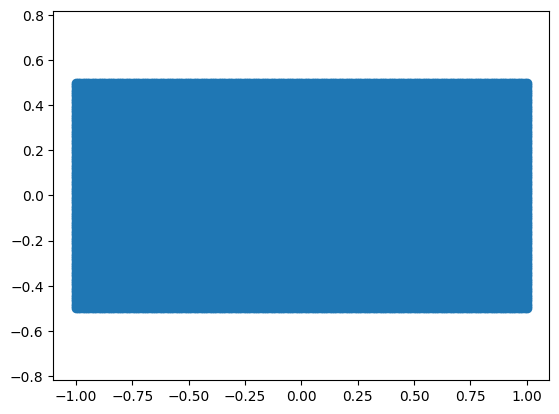

In [3]:
# Get grid.
grid = make_grid(
    x_length=grid_length_x,
    y_length=grid_length_y,
    nr_xs=grid_nr_xs,
    nr_ys=grid_nr_ys,
    make_plot=make_plots
)

In [4]:
# Get grid xs and ys.
xs, ys = grid

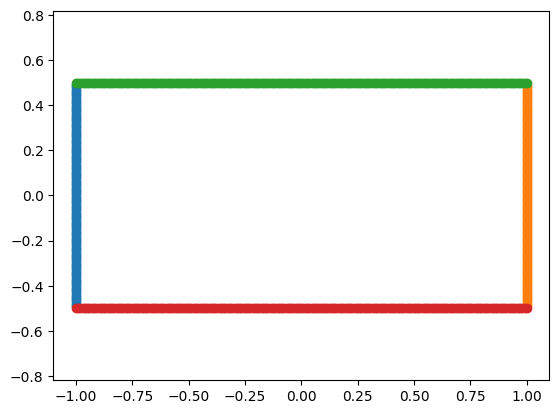

In [5]:
# Sample channel boundary.
inlet_xys, outlet_xys, left_wall_xys, right_wall_xys = sample_channel_boundary(grid, make_plots)

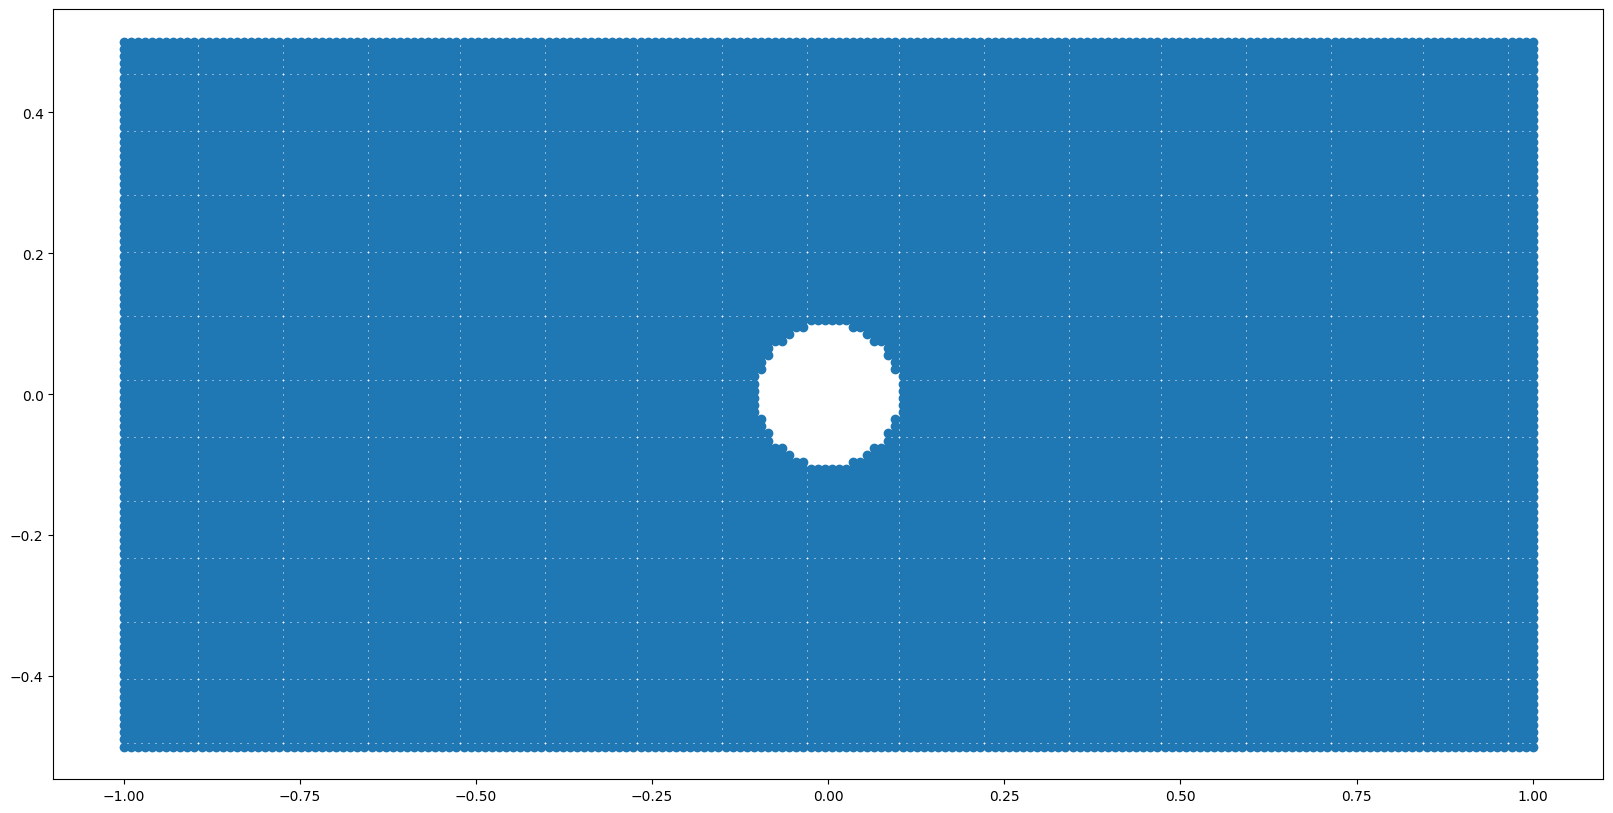

In [6]:
# Sample grid without cylinder.
channel_with_cylinder_xs, channel_with_cylinder_ys = exclude_cylinder_points(grid, cylinder_center, cylinder_radius, make_plot=make_plots)

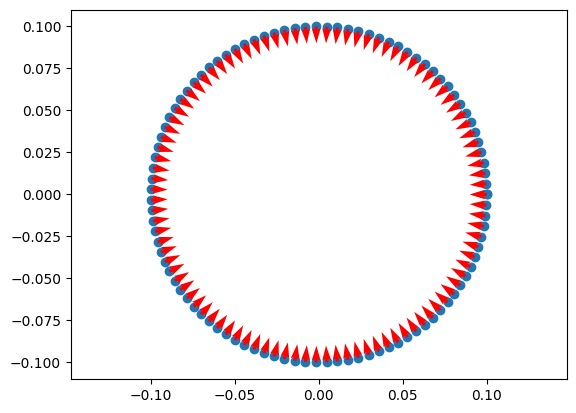

In [7]:
# Sample cylinder boundary.
cylinder_boundary_xs, cylinder_boundary_ys, cylinder_normals = sample_cylinder_boundary_and_compute_normals(
    cylinder_center,
    cylinder_radius,
    nr_samples_on_cylinder,
    make_plots,
)



# Get training data / compute exact solution

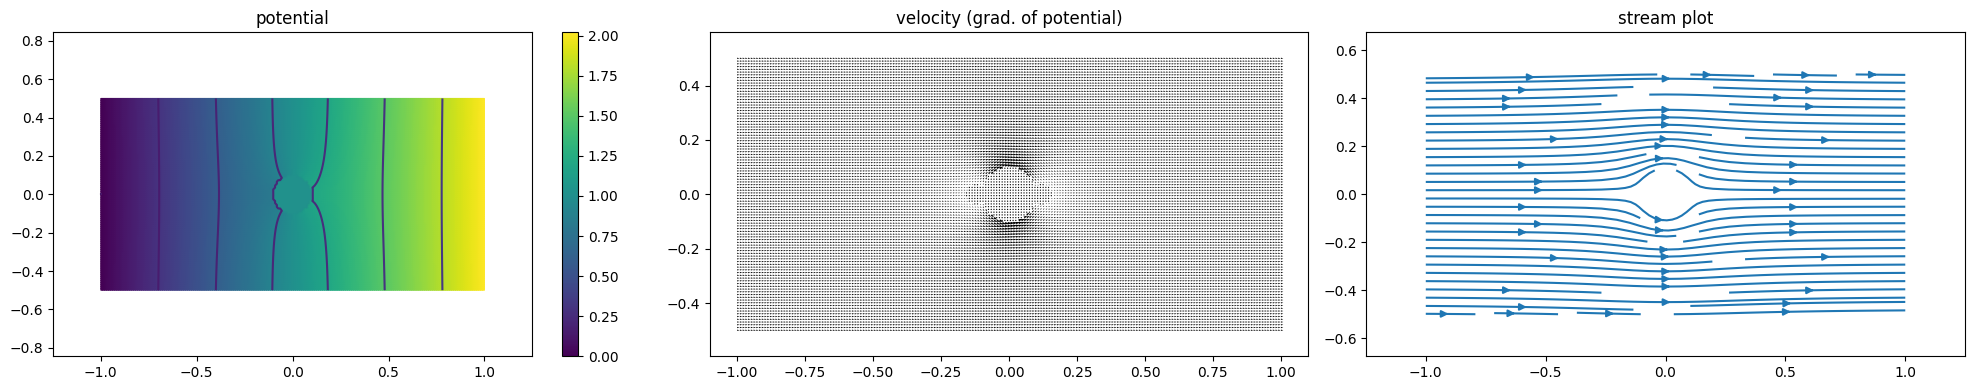

In [8]:
phi_exact, v_x_exact, v_y_exact = compute_analytical_solution(grid, U=1, R=cylinder_radius)

make_plot(phi_exact, grid, uv=(v_x_exact, v_y_exact))

# PINN architecture.

In [9]:
# define network architecture

class FullyConnected(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_outputs):
    super().__init__()
    self.input = nn.Sequential(
      nn.Linear(n_inputs, n_hidden),
      nn.Tanh(),
    )
    
    self.hidden = nn.Sequential(
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
    )
    for layer in self.hidden:
      if isinstance(layer, nn.Linear):
        init.xavier_uniform_(layer.weight)

    self.output = nn.Sequential(
    nn.Linear(n_hidden, n_outputs),
    )

  def forward(self, x):
    x = self.input(x)
    x = self.hidden(x)
    x = self.output(x)
    return x

# Training

In [10]:
# Prepare grid points for training.
grid_points_xs = channel_with_cylinder_xs.compressed()
grid_points_ys = channel_with_cylinder_ys.compressed()

grid_points_xys = np.zeros((grid_points_xs.shape[0], 2))
grid_points_xys[:, 0] = grid_points_xs
grid_points_xys[:, 1] = grid_points_ys

cylinder_boundary_xys = np.zeros((cylinder_boundary_xs.shape[0], 2))
cylinder_boundary_xys[:, 0] = cylinder_boundary_xs
cylinder_boundary_xys[:, 1] = cylinder_boundary_ys

physics_xys = np.vstack((grid_points_xys, cylinder_boundary_xys))

# Extract indices of boundary.
inlet_indices = np.where(physics_xys[:, 0] == -grid_length_x/2)
# Remove the walls.
# inlet_indices = (inlet_indices[0][1:-1],)

outlet_indices = np.where(physics_xys[:, 0] == grid_length_x/2)
# outlet_indices = (outlet_indices[0][1:-1],)

left_wall_indices = np.where(physics_xys[:, 1] == grid_length_y/2)
right_wall_indices = np.where(physics_xys[:, 1] == -grid_length_y/2)

# interior_indices = np.where((physics_xys[:, 1] < grid_length_y/2) & (physics_xys[:, 1] > -grid_length_y/2))

# plt.scatter(physics_xys[inlet_indices][:, 0], physics_xys[inlet_indices][:, 1])
# plt.scatter(physics_xys[outlet_indices][:, 0], physics_xys[outlet_indices][:, 1])
# plt.scatter(physics_xys[left_wall_indices][:, 0], physics_xys[left_wall_indices][:, 1])
# plt.scatter(physics_xys[right_wall_indices][:, 0], physics_xys[right_wall_indices][:, 1])
# plt.scatter(physics_xys[-nr_samples_on_cylinder:, 0], physics_xys[-nr_samples_on_cylinder:, 1])
# plt.axis('equal')
# plt.show()


In [11]:
# # Define the architecture.
# torch.manual_seed(123)

# # Convert to tensor. 
# physics_xys_tensor = torch.tensor(physics_xys, dtype=torch.float32).requires_grad_(True)
# cylinder_normals_tens = torch.tensor(cylinder_normals, dtype=torch.float32)

# pinn = FullyConnected(2, 64, 1)

# # Set optimizer
# optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)
# scheduler = StepLR(optimizer, step_size=2000, gamma=0.9)

# nr_steps = 100

# # Training loop.
# for i in range(nr_steps + 1):
#     optimizer.zero_grad()

#     # Get model predictions.
#     pinn_pred = pinn(physics_xys_tensor)

#     grad_f = torch.autograd.grad(
#         pinn_pred,
#         physics_xys_tensor,
#         grad_outputs=torch.ones_like(pinn_pred),
#         create_graph=True,
#     )[0]

#     print(grad_f[-nr_samples_on_cylinder:])

#     # Cylinder boundary constraint.
#     cylinder_grad = grad_f[-nr_samples_on_cylinder:]
#     cylinder_flux = cylinder_grad[:, 0] * cylinder_normals_tens[:, 0] + cylinder_grad[:, 1] * cylinder_normals_tens[:, 1]
#     cylinder_flux_loss = torch.mean(cylinder_flux**2)

#     physics_xys_tensor.detach().numpy()
#     xs = physics_xys_tensor[:, 0]
#     ys = physics_xys_tensor[:, 1]
    
#     plt.quiver(xs, ys, cylinder_normals[:, 0], cylinder_normals[:, 1], color='red', scale=100, scale_units='xy', angles='xy', label='Normal Vectors')
#     plt.axis('equal')
#     plt.show()

In [12]:
# Move all to GPU if available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


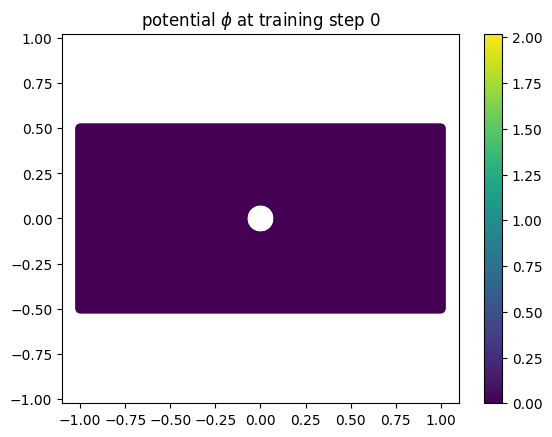

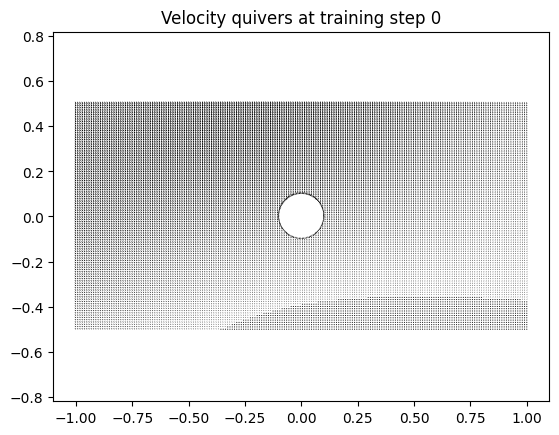

tensor(8.8827, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


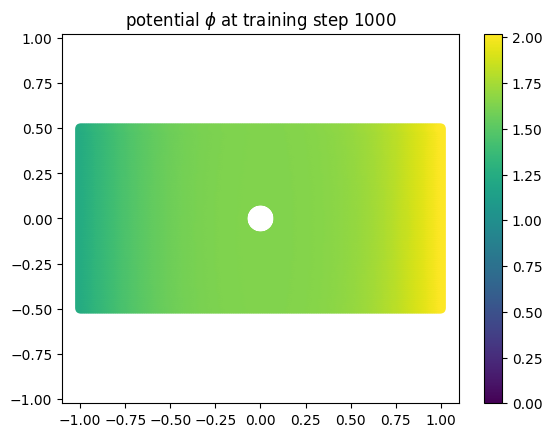

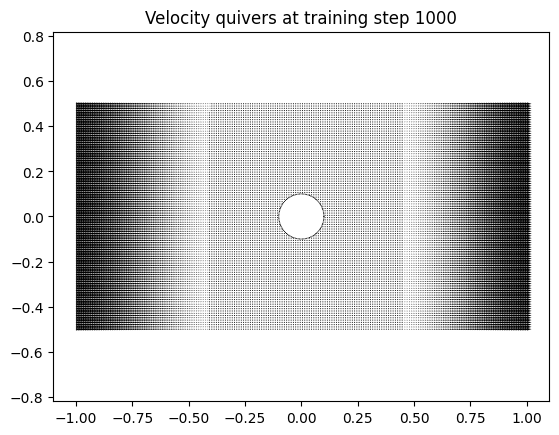

tensor(0.0008, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


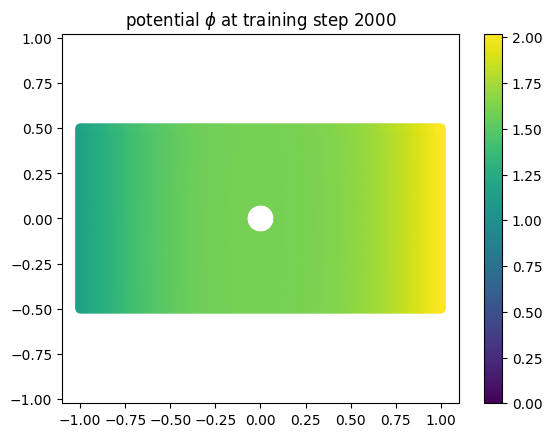

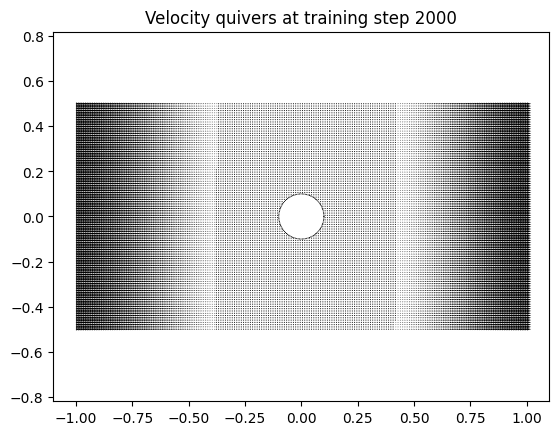

tensor(0.0007, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


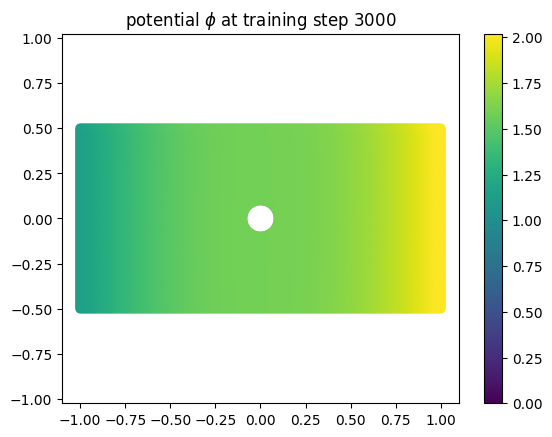

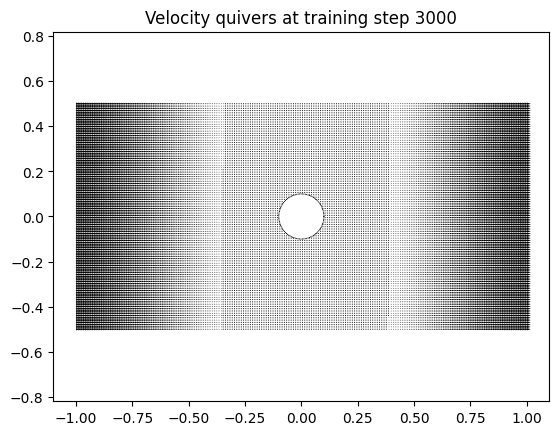

tensor(0.0008, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


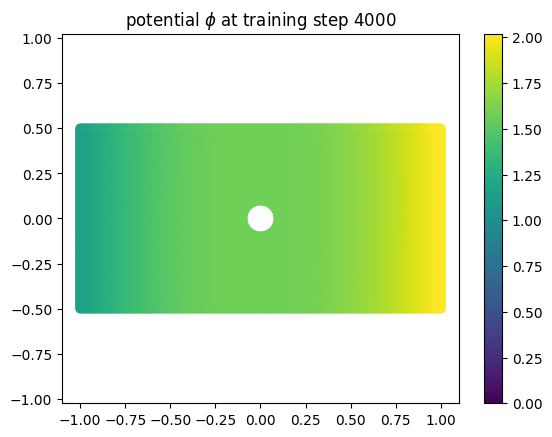

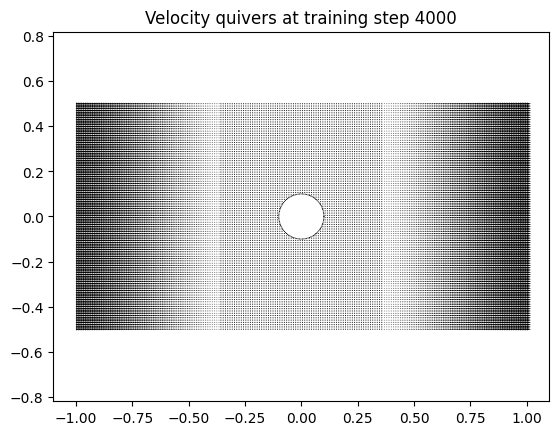

tensor(0.0009, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


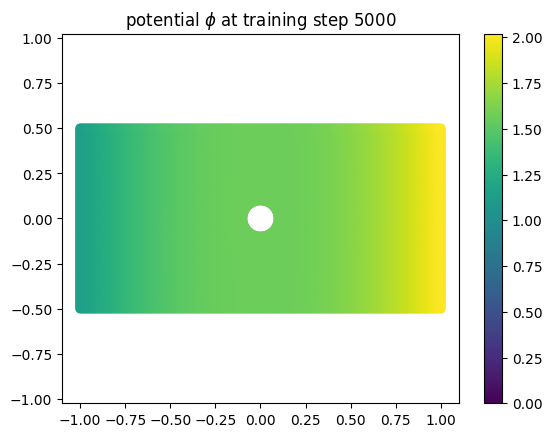

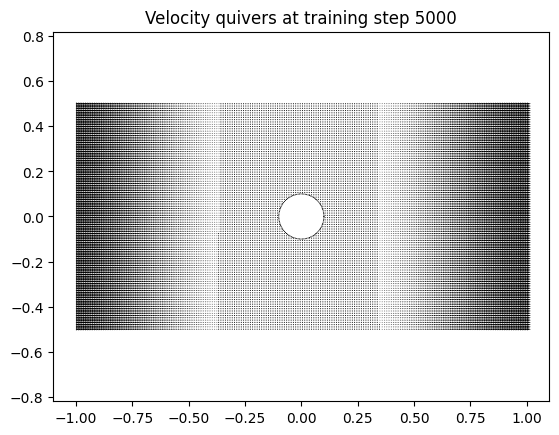

tensor(0.0008, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


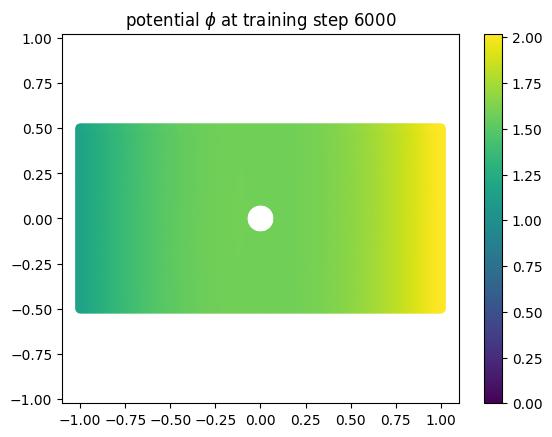

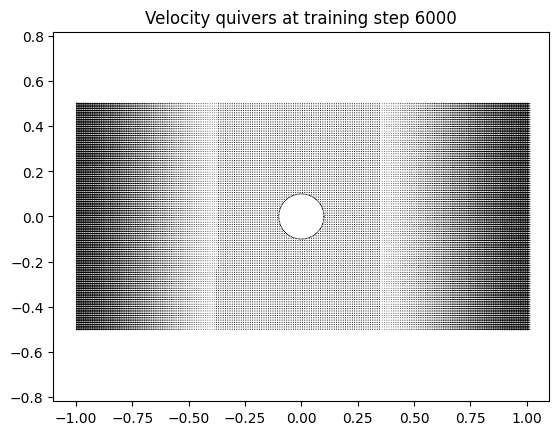

tensor(0.0009, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


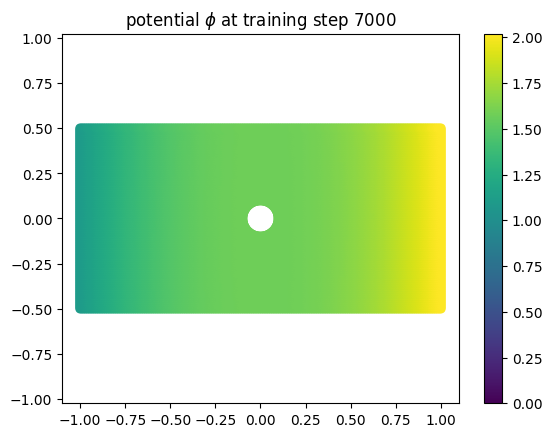

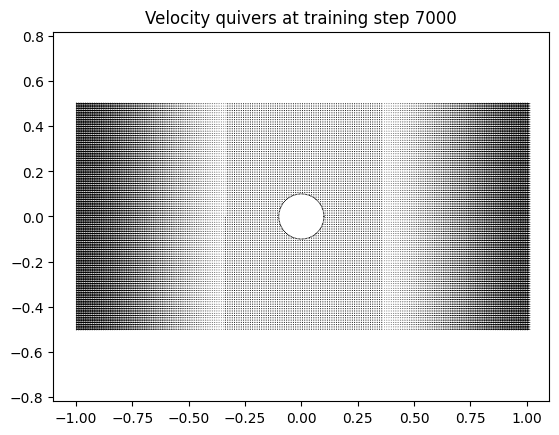

tensor(0.0007, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


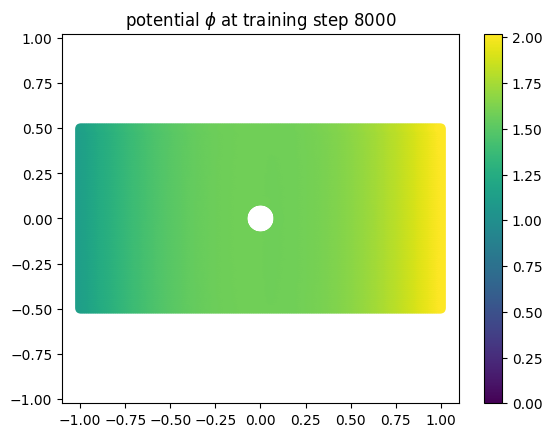

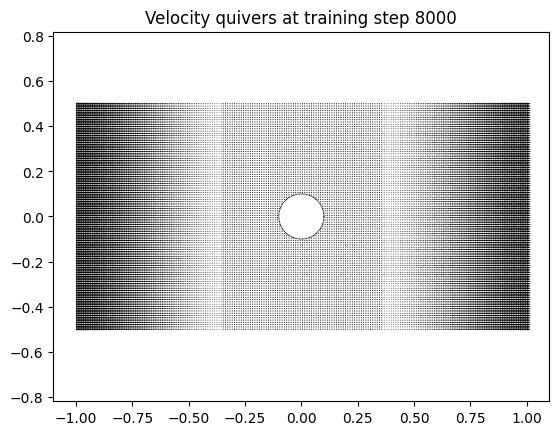

tensor(0.0011, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


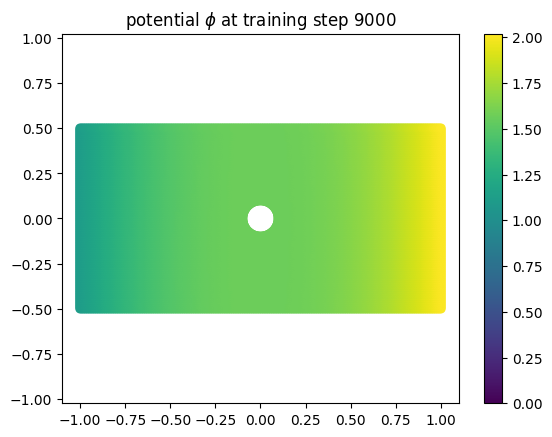

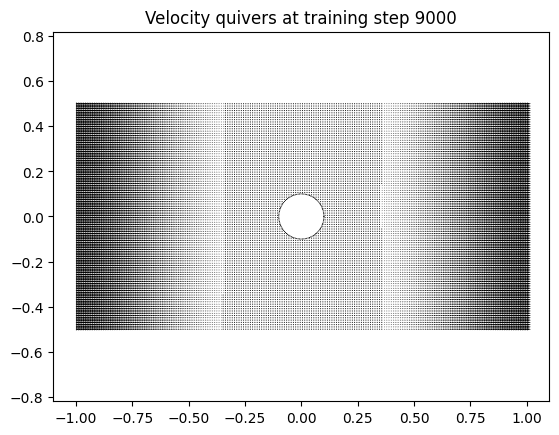

tensor(0.0009, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


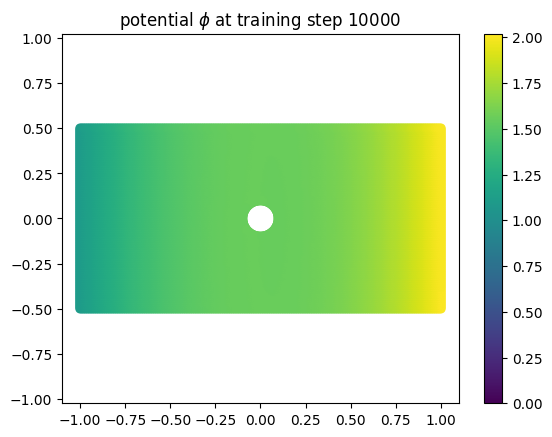

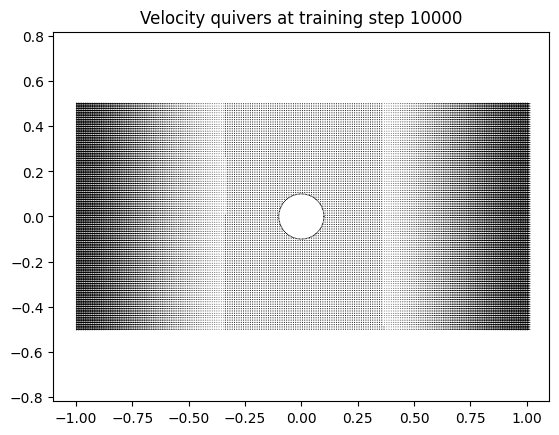

tensor(0.0008, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


In [14]:
torch.manual_seed(123)

# Define the architecture.
pinn = FullyConnected(2, 64, 1)

# Convert to tensors.
physics_xys_tensor = torch.tensor(physics_xys, dtype=torch.float32).requires_grad_(True)
cylinder_normals_tensor = torch.tensor(cylinder_normals, dtype=torch.float32)

# Move to device.
pinn.to(device)
physics_xys_tensor = physics_xys_tensor.to(device)
cylinder_normals_tensor = cylinder_normals_tensor.to(device)

# Specify data values.
inlet_values = torch.tensor(phi_exact[:, 0]).to(device)
inlet_velocity_x = torch.tensor(v_x_exact[:, 0]).to(device)
inlet_velocity_y = torch.tensor(0.0).to(device)

outlet_values = torch.tensor(phi_exact[:, -1]).to(device)
outlet_velocity_x = torch.tensor(v_x_exact[:, -1]).to(device)
outlet_velocity_y = torch.tensor(0.0).to(device)

# SoftAdapt.
softadapt_object = LossWeightedSoftAdapt(beta=1)
# initialize lists to keep track of loss values
values_of_inlet_loss = []
values_of_outlet_loss = []
values_of_pde_loss = []
values_of_walls_loss = []
values_of_cylinder_loss = []
values_of_outlet_velocity_loss = []
# initializing adaptive weights to all ones.
adapt_weights = torch.tensor([1, 1, 1, 1, 1, 1])
# Initial loss weights.
pde_initial_weight = 0.001
cylinder_initial_weight = 1


# Training hyperparameters. 
nr_steps = 10000
visualization_step = 1000
# Set optimizer
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=2000, gamma=0.9)


# Training loop.
for i in range(nr_steps + 1):
    optimizer.zero_grad()

    # Get model predictions.
    pinn_pred = pinn(physics_xys_tensor)

    grad_f = torch.autograd.grad(
        pinn_pred,
        physics_xys_tensor,
        grad_outputs=torch.ones_like(pinn_pred),
        create_graph=True,
    )[0]

    grad_f_x = grad_f[:, 0]
    grad_f_y = grad_f[:, 1]

    # Inlet constraint.
    inlet_velocity_loss = torch.mean((grad_f[inlet_indices][:, 0] - inlet_velocity_x) ** 2) + torch.mean((grad_f[inlet_indices][:, 1] - inlet_velocity_y)**2)
    inlet_data_loss = torch.mean((pinn_pred[inlet_indices]-inlet_values)**2)

    # Outlet constraint.
    outlet_grad = grad_f[outlet_indices]
    outlet_velocity_loss = torch.mean((outlet_grad[:, 0] - outlet_velocity_x)**2) + torch.mean((outlet_grad[:, 1] - outlet_velocity_y)**2)

    outlet_data_loss = torch.mean((pinn_pred[outlet_indices] - outlet_values)**2)

    # Channel walls constraints. No flux.
    left_wall_grad = grad_f[left_wall_indices]
    left_wall_loss = torch.mean(left_wall_grad[:, 1]**2)  # Normal direction is (0, 1).
    right_wall_grad = grad_f[right_wall_indices]
    right_wall_flux = -right_wall_grad[:, 1]  # Normal direction is (0,-1).
    right_wall_loss = torch.mean(right_wall_flux**2)
    walls_loss = right_wall_loss + left_wall_loss

    # Cylinder boundary constraint.
    cylinder_grad = grad_f[-nr_samples_on_cylinder:]
    cylinder_flux = cylinder_grad[:, 0] * cylinder_normals_tensor[:, 0] + cylinder_grad[:, 1] * cylinder_normals_tensor[:, 1]
    cylinder_flux_loss = cylinder_initial_weight*torch.mean(cylinder_flux**2)

    # Compute second order derivative.
    nabla_f_x = torch.autograd.grad(
        grad_f_x, 
        physics_xys_tensor, 
        grad_outputs=torch.ones_like(grad_f_x), 
        create_graph=True
    )[0]

    nabla_f_y = torch.autograd.grad(
        grad_f_y, 
        physics_xys_tensor, 
        grad_outputs=torch.ones_like(grad_f_y), 
        create_graph=True
    )[0]

    # PDE constraint. Laplace.
    residual = torch.mean(nabla_f_x[:, 0]**2) + torch.mean(nabla_f_y[:, 1]**2)
    pde_loss = pde_initial_weight * torch.mean(residual**2)

    # SoftAdapt. Keep track of each loss component
    values_of_inlet_loss.append(inlet_velocity_loss)
    values_of_outlet_loss.append(outlet_data_loss)
    values_of_outlet_velocity_loss.append(outlet_velocity_loss)
    values_of_pde_loss.append(pde_loss)
    values_of_walls_loss.append(walls_loss)
    values_of_cylinder_loss.append(cylinder_flux_loss)


    # SoftAdapt. Update weights for every fifth step
    if i % 5 == 0 and i != 0:
        adapt_weights = softadapt_object.get_component_weights(
            torch.tensor(values_of_inlet_loss), 
            torch.tensor(values_of_outlet_loss), 
            torch.tensor(values_of_pde_loss),
            torch.tensor(values_of_walls_loss),
            torch.tensor(values_of_cylinder_loss),
            torch.tensor(values_of_outlet_velocity_loss),
            verbose=False
        )

        # resetting the lists
        values_of_inlet_loss = []
        values_of_outlet_loss = []
        values_of_pde_loss = []
        values_of_walls_loss = []
        values_of_cylinder_loss = []
        values_of_outlet_velocity_loss = []

    loss = (
        adapt_weights[0]*inlet_velocity_loss
        + adapt_weights[1]*outlet_data_loss
        + adapt_weights[2]*pde_loss
        + adapt_weights[3]*walls_loss
        + adapt_weights[4]*cylinder_flux_loss
        + adapt_weights[5]*outlet_velocity_loss
    )

    loss.backward()
    optimizer.step()
    scheduler.step()

    if i % visualization_step == 0:
        phi = pinn(physics_xys_tensor).detach().cpu()
        phi_grad = grad_f.detach().cpu().numpy()
        xys = physics_xys_tensor.detach().cpu().numpy()

        fig, ax = plt.subplots()
        m = ax.scatter(xys[:, 0], xys[:, 1], c=phi, vmin=0, vmax=max(phi_exact[:, -1]))
        cbar = plt.colorbar(m, ax=ax)
        ax.axis("equal")
        ax.set_title(f"potential $\phi$ at training step {i}")

        fig, ax = plt.subplots()
        m = ax.quiver(xys[:, 0], xys[:, 1], phi_grad[:, 0], phi_grad[:, 1])
        ax.axis("equal")
        ax.set_title(f"Velocity quivers at training step {i}")
        plt.show()

        # fig, ax = plt.subplots()
        # m = ax.scatter(xys[:, 0], xys[:, 1], c=phi_grad[:, 1], vmin=0, vmax=2)
        # cbar = plt.colorbar(m, ax=ax)
        # ax.axis("equal")
        # ax.set_title(f"$d\phi / dy$ at training step {i}")
        # plt.show()
        print(loss)